In [ ]:
    import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

Эта функция загрузит реальную историю процентных ставок с сайта ЦБ РФ

In [ ]:
!pip install bs4 html5lib

In [ ]:
import requests
from bs4 import BeautifulSoup

# This does not work anymore :-(
def fetch_CBR_rates(date_from, date_to):
    def convert_date(date):
        if isinstance(date, dt.datetime):
            return date.strftime("%d.%m.%Y")
        elif isinstance(date, str):
            return date
        else:
            raise "fetch_CBR_rates: date arguments must be a DD.MM.YYYY string or a datetime"

    date_from = convert_date(date_from)
    date_to = convert_date(date_to)

    URL = f"http://www.cbr.ru/hd_base/zcyc_params/?UniDbQuery.Posted=True&UniDbQuery.From={date_from}&UniDbQuery.To={date_to}"
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")
    res = soup.find("table", {"class": "data"})
    df = pd.read_html(str(res).replace(",", "."))[0]
    df = df.droplevel(0, "columns").rename(columns={"Дата": "Date"})
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date").astype(float)
    df.columns = df.columns.astype(float)
    df /= 100

    return df

In [ ]:
with open("cbr.html", encoding="utf-8") as f:
    page = f.read()

soup = BeautifulSoup(page, "html.parser")
res = soup.find("table", {"class": "data"})
df = pd.read_html(str(res).replace(",", "."))[0]
df = df.droplevel(0, "columns").rename(columns={"Дата": "Date"})
df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y")
df = df.set_index("Date").astype(float)
df.columns = df.columns.astype(float)
df /= 100


In [ ]:
print(df)
current_rates = df.loc[df.index.max()]
print(current_rates)

             0.25    0.50    0.75    1.00    2.00    3.00    5.00    7.00   \
Date                                                                         
2020-12-30  0.0368  0.0387  0.0405  0.0418  0.0457  0.0491  0.0547  0.0587   
2020-12-29  0.0390  0.0400  0.0411  0.0421  0.0460  0.0494  0.0546  0.0584   
2020-12-28  0.0411  0.0418  0.0425  0.0433  0.0465  0.0497  0.0549  0.0586   
2020-12-25  0.0416  0.0423  0.0430  0.0437  0.0468  0.0500  0.0551  0.0588   
2020-12-24  0.0420  0.0426  0.0432  0.0439  0.0470  0.0503  0.0554  0.0589   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2018-01-10  0.0639  0.0645  0.0652  0.0658  0.0675  0.0684  0.0704  0.0726   
2018-01-09  0.0637  0.0641  0.0645  0.0650  0.0668  0.0680  0.0703  0.0726   
2018-01-05  0.0641  0.0643  0.0647  0.0652  0.0673  0.0688  0.0711  0.0731   
2018-01-04  0.0579  0.0599  0.0618  0.0635  0.0675  0.0689  0.0709  0.0729   
2018-01-03  0.0616  0.0627  0.0638  0.0649  0.0679  0.0693  0.07

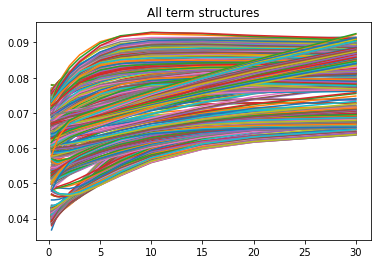

In [ ]:
df.T.plot(legend=None)
plt.title("All term structures");

<AxesSubplot:>

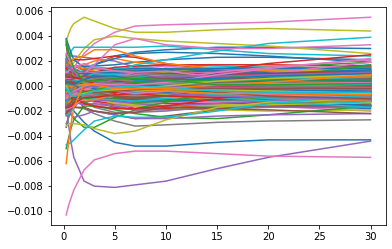

In [ ]:
df.diff().T.plot(legend=None)

In [ ]:
def bond_cashflows(maturity, coupon_rate, coupon_frequency):
    if coupon_frequency == 0:
        assert coupon_rate == 0, "Bond must be zero-coupon for zero frequency"
        return pd.DataFrame([1], index=[maturity])

    assert maturity * coupon_frequency == np.round(
        maturity * coupon_frequency
    ), "This is a very simple function, it does not calculate the accrued interest"

    cashflows = np.full(maturity * coupon_frequency, coupon_rate / coupon_frequency)
    cashflows[-1] += 1
    times = np.linspace(0, maturity, maturity * coupon_frequency + 1)[1:]
    df = pd.Series(cashflows, index=times)
    return df


bond_maturity = 3  # years
bond_coupon_rate = 5 / 100  # as a fraction
bond_frequency = 2  # per year

cashflows = bond_cashflows(bond_maturity, bond_coupon_rate, bond_frequency)
cashflows

0.5    0.025
1.0    0.025
1.5    0.025
2.0    0.025
2.5    0.025
3.0    1.025
dtype: float64

In [ ]:
# This function does the same thing but tries to calculate the accrued interest
# For actual calculations this should be fine-tuned still a bit more to include
# correct year fractions between the payment dates
def bond_cashflows_better(maturity, coupon_rate, coupon_frequency):
    time_delta = 1 / coupon_frequency
    coupon = coupon_rate * time_delta
    cashflow_times = np.arange(maturity, 0, step=-time_delta)[::-1]
    # accrued interest is in fact paid right away
    AI = (time_delta - cashflow_times[0]) * coupon
    cashflow_amounts = np.full(cashflow_times.size, coupon)
    cashflow_amounts[-1] += 1
    cashflow_amounts = np.hstack([-AI, cashflow_amounts])
    cashflow_times = np.hstack([0, cashflow_times])
    return pd.Series(cashflow_amounts, index=cashflow_times)


bond_cashflows_better(2.25, 0.2, 2)

0.00   -0.025
0.25    0.100
0.75    0.100
1.25    0.100
1.75    0.100
2.25    1.100
dtype: float64

In [ ]:
def discount_factors(interest_rates, period):
    terms = interest_rates.index.to_numpy()
    if period == -1:  # continuous compounding
        return np.exp(-interest_rates * terms)
    elif period == 0:  # simple interest
        return 1.0 / (1.0 + interest_rates * terms)
    else:  # compound interest `period` times a year
        return 1.0 / (1.0 + interest_rates / period) ** (terms * period)


print(discount_factors(current_rates, 1))
# 365 times a year should be pretty close to continuous
assert np.all(np.isclose(discount_factors(current_rates, 365), discount_factors(current_rates, -1), rtol=0.01))

0.25     0.991006
0.50     0.981194
0.75     0.970663
1.00     0.959877
2.00     0.914504
3.00     0.866063
5.00     0.766223
7.00     0.670795
10.00    0.544369
15.00    0.382314
20.00    0.268272
30.00    0.132849
Name: 2020-12-30 00:00:00, dtype: float64


In [ ]:
def interpolate_term_structure(interest_rates, terms):
    # we are OK with the very short rates being equal to the shortest rate in the sample
    # however very long rates probably need a special function to interpolate
    rates = np.interp(terms, interest_rates.index, interest_rates, right=np.nan)
    return pd.Series(rates, index=terms, dtype=interest_rates.dtype)


print(interpolate_term_structure(current_rates, cashflows.index))

0.5    0.03870
1.0    0.04180
1.5    0.04375
2.0    0.04570
2.5    0.04740
3.0    0.04910
dtype: float64


In [ ]:
def bond_price(cashflows, interest_rates, period=-1):
    d = discount_factors(interpolate_term_structure(interest_rates, cashflows.index), period=period)
    return (cashflows * d).sum(skipna=False)


bond_price(cashflows, current_rates)

1.0015430026431889

In [ ]:
# this shouldn't work as we don't have a 40-year rate
bond_price(bond_cashflows(40, 0.12, 1), current_rates)

nan

In [ ]:
def bond_duration(cashflows, interest_rates, period=-1):
    d = discount_factors(interpolate_term_structure(interest_rates, cashflows.index), period=period)
    terms = pd.Series(cashflows.index, index=cashflows.index)
    return (cashflows * terms * d).sum() / bond_price(cashflows, interest_rates, period)


bond_duration(cashflows, current_rates)

2.8219818169077064

In [ ]:
# check the definition of duration
dr = 1e-10
D = - (bond_price(cashflows, current_rates + dr) - bond_price(cashflows, current_rates)) / dr / bond_price(cashflows, current_rates)
print(D)
assert np.isclose(D, bond_duration(cashflows, current_rates), rtol=1e-5)

2.821980398603076


In [ ]:
def bond_convexity(cashflows, interest_rates, period=-1):
    d = discount_factors(interpolate_term_structure(interest_rates, cashflows.index), period=period)
    terms = pd.Series(cashflows.index, index=cashflows.index)
    return (cashflows * terms ** 2 * d).sum() / bond_price(cashflows, interest_rates, period)


bond_convexity(cashflows, current_rates)

8.261588959933205

## Now let's estimate VaR for a bond

True historical simulations

VaR is 0.48%


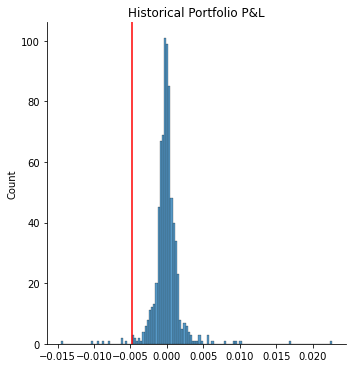

In [ ]:
current_price = bond_price(cashflows, current_rates)

dr = df.diff().dropna()
scenario_rates = (current_rates + dr).reset_index().drop("Date", axis=1)
scenario_prices = scenario_rates.apply(lambda x: bond_price(cashflows, x), axis=1, raw=False)
scenario_returns = (scenario_prices - current_price) / current_price

sns.displot(scenario_returns, kind="hist")
VaR = -scenario_returns.quantile(0.01, interpolation="higher")
plt.axvline(-VaR, color="r")
plt.title("Historical Portfolio P&L")
print(f"VaR is {VaR*100:.2f}%")

## Parallel shift approximation

Possible changes with MAX: 0.33%, possible changes with MEAN: 0.18%


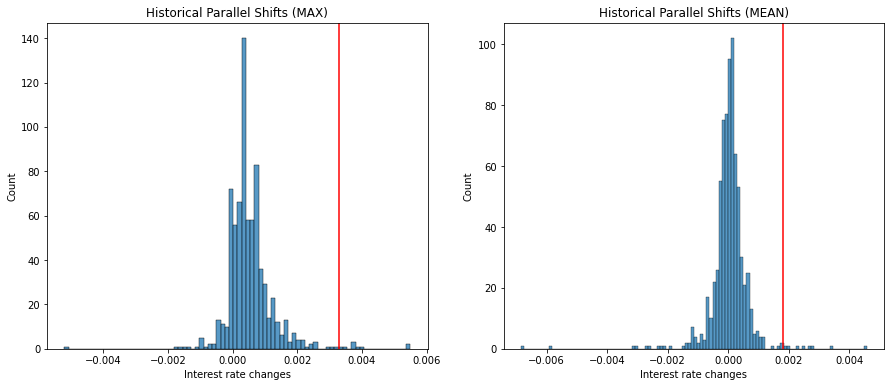

In [ ]:
def parallel_shift_approximation(rates, aggregation_function):
    dr = aggregation_function(self=df.diff().dropna(), axis=1)
    max_rate_change = dr.quantile(0.99, interpolation="lower")

    sns.histplot(dr)
    plt.axvline(max_rate_change, color="r")
    plt.xlabel("Interest rate changes")
    return max_rate_change


plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
change_max = parallel_shift_approximation(df, pd.DataFrame.max)
plt.title("Historical Parallel Shifts (MAX)")
plt.subplot(1, 2, 2)
change_mean = parallel_shift_approximation(df, pd.DataFrame.mean)
plt.title("Historical Parallel Shifts (MEAN)")
print(f"Possible changes with MAX: {change_max*100:.2f}%, possible changes with MEAN: {change_mean*100:.2f}%")

Now we can use durations!

In [ ]:
current_duration = bond_duration(cashflows, current_rates)
VaR_max = change_max * current_duration
VaR_mean = change_mean * current_duration
print(f"VaR with MAX: {VaR_max*100:.2f}%, VaR with MEAN: {VaR_mean*100:.2f}%")

VaR with MAX: 0.93%, VaR with MEAN: 0.51%


Actually, we can just take all rates as risk factors -- as we did according to the Historical Simulation approach.


In [ ]:
# sensitivities = ...?

We need the sensitivities. For this, we'll calculate the **Key Rate Durations**, which are just exactly what we want.

In [ ]:
dr = 1e-8
term_structure_shifts = np.eye(current_rates.size)  # only change 1 rate at a time
key_rate_durations = pd.Series(
    [
        (
            bond_price(cashflows, current_rates + dr * term_structure_shifts[k])
            - bond_price(cashflows, current_rates - dr * term_structure_shifts[k])
        )
        / (2 * dr)
        / current_price
        for k in range(term_structure_shifts.shape[0])
    ],
    index=df.columns,
)
key_rate_durations

0.25     0.000000
0.50    -0.012242
0.75     0.000000
1.00    -0.041472
2.00    -0.090809
3.00    -2.677459
5.00     0.000000
7.00     0.000000
10.00    0.000000
15.00    0.000000
20.00    0.000000
30.00    0.000000
dtype: float64

In [ ]:
mean_rate_changes = df.diff().dropna().mean()
portfolio_mu = - (key_rate_durations @ mean_rate_changes)
portfolio_sigma = np.sqrt(key_rate_durations @ df.diff().cov() @ key_rate_durations)
VaR = - ss.norm(portfolio_mu, portfolio_sigma).ppf(0.01)
print(f"Delta-normal VaR: {VaR*100:.2f}%")

Delta-normal VaR: 0.46%


However, there is a slight problem.

<AxesSubplot:>

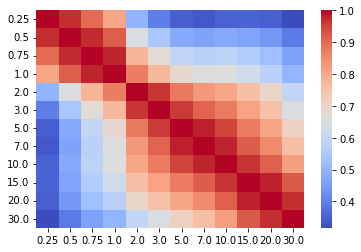

In [ ]:
sns.heatmap(df.diff().corr(), cmap='coolwarm')

They are too dependent (multicollinearity issues). These VIFs are too big!

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

[variance_inflation_factor(df.diff().dropna().values, k) for k in range(df.shape[1])]

[91.18719619635071,
 292.5126211236135,
 205.0919378749434,
 158.0800010916588,
 73.28813207908553,
 115.40833803111957,
 172.40747366206904,
 156.10177897377318,
 142.91003393527728,
 193.9733825336091,
 176.46890746541013,
 40.708242686628985]

So let's conduct a PCA analysis!

/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


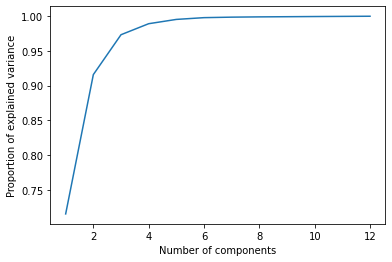

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(df.diff().dropna())
plt.plot(np.arange(1, len(pca.components_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Proportion of explained variance");


Seems like 3 components would be quite enough...

In [ ]:
K = 3

The 3 factors only explain a fraction of the total variance:

In [ ]:
explained_variance = np.sum(pca.explained_variance_[:K])
unexplained_variance = np.sum(pca.explained_variance_[K:])
np.sqrt(explained_variance), np.sqrt(unexplained_variance)

(0.0026730774319868697, 0.00044210587690029227)

We'll add this variance later...

/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


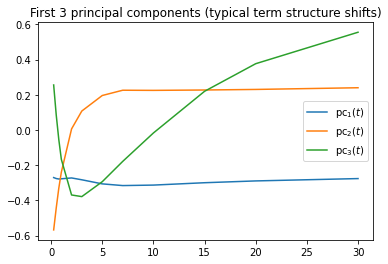

In [ ]:

data = df.diff().dropna()
pca = PCA(n_components=K).fit(data)
factors = pca.transform(data)
plt.plot(data.columns, pca.components_.T)
plt.legend([f"pc$_{i}(t)$" for i in range(1, K+1)])
plt.title(f'First {K} principal components (typical term structure shifts)');

$$
y = AX
$$
$$
X=A^Ty
$$

In [ ]:
A = pd.DataFrame(pca.components_, columns=df.columns)
print(A)

      0.25      0.50      0.75      1.00      2.00      3.00      5.00   \
0 -0.270518 -0.275982 -0.278624 -0.277401 -0.272617 -0.283026 -0.306274   
1 -0.567863 -0.443459 -0.331337 -0.239669  0.006006  0.107516  0.195814   
2  0.255592  0.085327 -0.053743 -0.166963 -0.369335 -0.378621 -0.293936   

      7.00      10.00     15.00     20.00     30.00  
0 -0.315939 -0.313185 -0.299743 -0.289493 -0.276205  
1  0.225774  0.224959  0.227075  0.230261  0.239891  
2 -0.178512 -0.017066  0.219721  0.376536  0.555204  


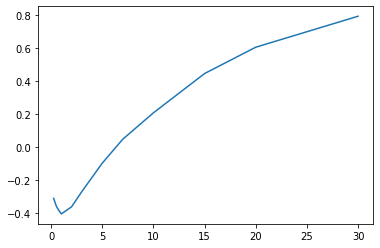

In [ ]:
plt.plot(data.columns, pca.components_[1, :] + pca.components_[2, :])

We now have 3 risk factors in `factors` and the sensitivities of all rates to them in `pca.components_.T`

In [ ]:
rate_sensitivities = pd.DataFrame(pca.components_.T, index=df.columns)
print(rate_sensitivities)

              0         1         2
0.25  -0.270518 -0.567863  0.255592
0.50  -0.275982 -0.443459  0.085327
0.75  -0.278624 -0.331337 -0.053743
1.00  -0.277401 -0.239669 -0.166963
2.00  -0.272617  0.006006 -0.369335
3.00  -0.283026  0.107516 -0.378621
5.00  -0.306274  0.195814 -0.293936
7.00  -0.315939  0.225774 -0.178512
10.00 -0.313185  0.224959 -0.017066
15.00 -0.299743  0.227075  0.219721
20.00 -0.289493  0.230261  0.376536
30.00 -0.276205  0.239891  0.555204


In [ ]:
# PCA factors are independent by construction
factor_covariance = pd.DataFrame(np.diag(pca.explained_variance_))
factor_covariance

,0,1,2
0,0.000005,0.000000,0.000000e+00
1,0.000000,0.000001,0.000000e+00
2,0.000000,0.000000,4.221128e-07


$$
\Delta r = Ay+\sigma\cdot \varepsilon,\quad \varepsilon\sim N(0,\,I)
$$
$cov(y)=$`factor_covariance`

In [ ]:
pca.n_features_

12

In [ ]:
term_structure_covariance = rate_sensitivities @ factor_covariance @ rate_sensitivities.T
# Now we distribute the unexplained variance evenly across all rates
# noise_variance_ is already the average
additional_variance = np.eye(pca.n_features_) * pca.noise_variance_ 
term_structure_covariance += additional_variance
# cov(Δr)
term_structure_covariance

,0.25,0.50,0.75,1.00,2.00,3.00,5.00,7.00,10.00,15.00,20.00,30.00
0.25,9.087944e-07,7.723226e-07,6.672100e-07,5.765202e-07,3.422326e-07,2.710339e-07,2.392657e-07,2.403621e-07,2.545523e-07,2.592395e-07,2.589362e-07,2.512829e-07
0.50,7.723226e-07,7.144945e-07,6.182977e-07,5.525214e-07,3.776963e-07,3.260798e-07,3.050851e-07,3.036575e-07,3.060159e-07,2.936875e-07,2.824041e-07,2.632947e-07
0.75,6.672100e-07,6.182977e-07,5.922688e-07,5.265559e-07,4.041512e-07,3.700026e-07,3.589536e-07,3.558362e-07,3.485443e-07,3.224790e-07,3.023745e-07,2.741840e-07
1.00,5.765202e-07,5.525214e-07,5.265559e-07,5.220843e-07,4.208635e-07,4.008095e-07,3.974960e-07,3.928489e-07,3.777489e-07,3.407394e-07,3.136368e-07,2.782940e-07
2.00,3.422326e-07,3.776963e-07,4.041512e-07,4.208635e-07,4.694603e-07,4.649845e-07,4.858317e-07,4.819325e-07,4.528151e-07,3.966823e-07,3.575952e-07,3.108112e-07
3.00,2.710339e-07,3.260798e-07,3.700026e-07,4.008095e-07,4.649845e-07,5.197393e-07,5.330205e-07,5.336802e-07,5.036576e-07,4.461788e-07,4.063938e-07,3.596243e-07
5.00,2.392657e-07,3.050851e-07,3.589536e-07,3.974960e-07,4.858317e-07,5.330205e-07,6.070943e-07,5.952418e-07,5.705482e-07,5.201686e-07,4.851531e-07,4.444023e-07
7.00,2.403621e-07,3.036575e-07,3.558362e-07,3.928489e-07,4.819325e-07,5.336802e-07,5.952418e-07,6.342615e-07,5.955406e-07,5.561093e-07,5.283549e-07,4.960602e-07
10.00,2.545523e-07,3.060159e-07,3.485443e-07,3.777489e-07,4.528151e-07,5.036576e-07,5.705482e-07,5.955406e-07,6.112979e-07,5.664775e-07,5.495541e-07,5.296159e-07
15.00,2.592395e-07,2.936875e-07,3.224790e-07,3.407394e-07,3.966823e-07,4.461788e-07,5.201686e-07,5.561093e-07,5.664775e-07,5.897144e-07,5.674805e-07,5.663680e-07


In [ ]:
print(rate_sensitivities @ factor_covariance @ rate_sensitivities.T)

              0.25          0.50          0.75          1.00          2.00   \
0.25   8.870769e-07  7.723226e-07  6.672100e-07  5.765202e-07  3.422326e-07   
0.50   7.723226e-07  6.927770e-07  6.182977e-07  5.525214e-07  3.776963e-07   
0.75   6.672100e-07  6.182977e-07  5.705513e-07  5.265559e-07  4.041512e-07   
1.00   5.765202e-07  5.525214e-07  5.265559e-07  5.003668e-07  4.208635e-07   
2.00   3.422326e-07  3.776963e-07  4.041512e-07  4.208635e-07  4.477428e-07   
3.00   2.710339e-07  3.260798e-07  3.700026e-07  4.008095e-07  4.649845e-07   
5.00   2.392657e-07  3.050851e-07  3.589536e-07  3.974960e-07  4.858317e-07   
7.00   2.403621e-07  3.036575e-07  3.558362e-07  3.928489e-07  4.819325e-07   
10.00  2.545523e-07  3.060159e-07  3.485443e-07  3.777489e-07  4.528151e-07   
15.00  2.592395e-07  2.936875e-07  3.224790e-07  3.407394e-07  3.966823e-07   
20.00  2.589362e-07  2.824041e-07  3.023745e-07  3.136368e-07  3.575952e-07   
30.00  2.512829e-07  2.632947e-07  2.741840e-07  2.7

In [ ]:
np.eye(pca.n_features_) * pca.noise_variance_ 

array([[2.17175118e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.17175118e-08, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.17175118e-08, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.17175118e-08,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.17175118e-08, 0.00000000e+00, 0.00000000e+00, 0.00

We can now proceed as usual... We'll still need the **Key Rate Durations** discussed above.


In [ ]:
portfolio_mu = 
portfolio_sigma = 
VaR = - ss.norm(portfolio_mu, portfolio_sigma).ppf(0.01)
print(f"VaR computed via PCA is {VaR*100:.2f}%")

VaR computed via PCA is 0.46%


But there is an easier way!

Let's calculate the so-called **Partial Durations** -- these are the sensitivities to a small non-parallel term structure shift specified by a given factor:

$$
-\left(\frac{PV(r(\cdot)+h\,f(\cdot))-PV(r(\cdot))}{h}\right)/PV(r(\cdot))
$$

In [ ]:
def partial_duration(pricing_function, term_structure, factor, h=1e-8):
#                        PV(.)               r(.)        f(.)    h
    return -(pricing_function(term_structure + h * factor) - pricing_function(term_structure)) / h / pricing_function(term_structure)

In [ ]:
def partial_duration(pricing_function, term_structure, factor, h=1e-8):
#                        PV(.)               r(.)        f(.)    h
    pricing_function()

In [ ]:
partial_durations = pd.Series([
  partial_duration(lambda rates: bond_price(cashflows, rates), current_rates, pca.components_[k])
  for k in range(K)
])
partial_durations

0   -0.797430
1    0.273048
2   -1.053161
dtype: float64

In [ ]:
mean_factor_changes = np.diff(pca.transform(df), axis=0).mean(axis=0)
portfolio_mu = - partial_durations.T @ mean_factor_changes
portfolio_sigma = np.sqrt(partial_durations @ (rate_sensitivities.T @ term_structure_covariance @ rate_sensitivities) @ partial_durations)

/shared-libs/python3.8/py/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
partial_durations

0   -0.797430
1    0.273048
2   -1.053161
dtype: float64

Now finally -- our VaR:

In [ ]:
VaR = - ss.norm(portfolio_mu, portfolio_sigma).ppf(0.01)
print(f"VaR computed via PCA is {VaR*100:.2f}%")

VaR computed via PCA is 0.47%


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dc69f171-f4bb-4c21-8857-3bf9aef78ad4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>